## Preparing the environment

In [1]:
pip install openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.2/242.2 KB 515.9 kB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Introduction

Churn rate (also known as attrition rate) is a measure of number of individuals moving out of a collective group over a specific period. Churn refers to the proportion of customers or subscribers who leave a supplier in a given period for several reasons. It could be that the competitors offer a more compelling service, a cheaper price or customer dissatisfaction. 

Churn is related to the average customer life cycle. An annual churn of 25% means an average customer life cycle of 4 years. The churn rate can be minimized by creating barriers which discourage customers to change suppliers (contractual binding periods, use of proprietary technology, value-added services, unique business models, etc.), or through retention activities such as loyalty programs. 

In most circumstances churn is seen as indicating that customers are dissatisfied with a service. However, in some industries whose services delivers on a promise, churn is considered as a positive signal, such as the health care services, weight loss services and online dating platforms

In this notebook, we're trying to predict the churn rate of customers of a bank.

In [3]:
# load the file

data = pd.read_excel('../input/churn-modelling/Churn-Modelling.xlsx')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


From a glance at the dataset, we see that there's a redundant RowNumber column which needs to be dropped. 
We also have 3 categorical features - Surname, Geography and Gender

In [4]:
# drop the columns
data = data.drop(columns=['RowNumber'])

data['Gender'].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

In [5]:
# let's see the distribution of the target
data['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

From the dataset documentation, 0 means the customer did not exit (churn) and 1 means the customer did. Let's view this with seaborn countplot

[Text(0.5, 0, 'Exited'), Text(0, 0.5, 'Count')]

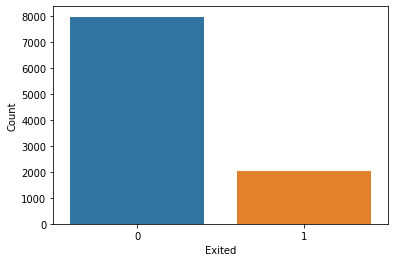

In [6]:
sns.countplot(x='Exited', data=data).set(xlabel='Exited', ylabel='Count')

As we see, we have an imbalanced dataset for the classification task. Let's split the dataset into train and test to avoid any future work recognizing the patterns from the test set using sklearn's StratifiedShuffleSplit

In [7]:
len(data)

10000

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(data, data['Exited']):
    train = data.iloc[train_index].reset_index(drop=True)
    test = data.iloc[test_index].reset_index(drop=True)

train.shape, test.shape

((8000, 13), (2000, 13))

In [9]:
# let's see if the class imbalance is maintained in both train and test sets

train['Exited'].value_counts()

0    6370
1    1630
Name: Exited, dtype: int64

In [10]:
test['Exited'].value_counts()

0    1593
1     407
Name: Exited, dtype: int64

In both cases, we see that the majority class (0) has 3.9x more observations than the minority class (1). 
Let's gain some insight from the dataset.

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       8000 non-null   int64  
 1   Surname          8000 non-null   object 
 2   CreditScore      8000 non-null   int64  
 3   Geography        8000 non-null   object 
 4   Gender           8000 non-null   object 
 5   Age              8000 non-null   int64  
 6   Tenure           8000 non-null   int64  
 7   Balance          8000 non-null   float64
 8   NumOfProducts    8000 non-null   int64  
 9   HasCrCard        8000 non-null   int64  
 10  IsActiveMember   8000 non-null   int64  
 11  EstimatedSalary  8000 non-null   float64
 12  Exited           8000 non-null   int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 812.6+ KB


In [12]:
train.describe()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,8.000000e+03,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.00000
mean,1.569088e+07,650.752500,38.946625,5.016625,76381.207499,1.529500,0.708750,0.514875,99730.811581,0.20375
std,7.193619e+04,96.596432,10.526876,2.896791,62302.053597,0.581741,0.454367,0.499810,57335.116540,0.40281
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.00000
25%,1.562869e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.000000,0.000000,50691.817500,0.00000
50%,1.568995e+07,652.000000,37.000000,5.000000,97055.145000,1.000000,1.000000,1.000000,99446.940000,0.00000
75%,1.575327e+07,717.000000,44.000000,8.000000,127633.195000,2.000000,1.000000,1.000000,148527.730000,0.00000
max,1.581569e+07,850.000000,92.000000,10.000000,238387.560000,4.000000,1.000000,1.000000,199992.480000,1.00000


In [13]:
train.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15588614,Walton,753,France,Male,57,7,0.00,1,1,0,159475.08,1
1,15641158,Belcher,739,Germany,Male,32,3,102128.27,1,1,0,63981.37,1
2,15750014,Chikere,755,Germany,Female,37,0,113865.23,2,1,1,117396.25,0
3,15663964,Pagnotto,561,France,Male,37,5,0.00,2,1,0,83093.25,0
4,15573520,Rhodes,692,Germany,Male,49,6,110540.43,2,0,1,107472.99,0


In [14]:
train['Geography'].value_counts()

France     3993
Germany    2005
Spain      2002
Name: Geography, dtype: int64

We'll drop the Surname feature since it has no contribution to the target we're trying to predict and onehotencode the features Gender and Geography

In [15]:
# drop the columns
train = train.drop(columns=['Surname'])
test = test.drop(columns=['Surname'])

train.head()

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15588614,753,France,Male,57,7,0.00,1,1,0,159475.08,1
1,15641158,739,Germany,Male,32,3,102128.27,1,1,0,63981.37,1
2,15750014,755,Germany,Female,37,0,113865.23,2,1,1,117396.25,0
3,15663964,561,France,Male,37,5,0.00,2,1,0,83093.25,0
4,15573520,692,Germany,Male,49,6,110540.43,2,0,1,107472.99,0


In [16]:
# let's ohe the Geography feature and Gender
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()

# for Geograhpy 
ohe.fit(train[['Geography']])
temp = ohe.transform(train[['Geography']]).toarray()
temp = pd.DataFrame(temp, columns=ohe.get_feature_names_out())
train = pd.concat([train, temp], axis=1).drop(columns=['Geography'])

temp = ohe.transform(test[['Geography']]).toarray()
temp = pd.DataFrame(temp, columns = ohe.get_feature_names_out())
test = pd.concat([test, temp], axis=1).drop(columns=['Geography'])

# for Gender
ohe = OneHotEncoder()
ohe.fit(train[['Gender']])
temp = ohe.transform(train[['Gender']]).toarray()
temp = pd.DataFrame(temp, columns=ohe.get_feature_names_out())
train = pd.concat([train, temp], axis=1).drop(columns=['Gender'])

temp = ohe.transform(test[['Gender']]).toarray()
temp = pd.DataFrame(temp, columns=ohe.get_feature_names_out())
test = pd.concat([test, temp], axis=1).drop(columns=['Gender'])

train.shape, test.shape

((8000, 15), (2000, 15))

In [17]:
train.head()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,15588614,753,57,7,0.00,1,1,0,159475.08,1,1.0,0.0,0.0,0.0,1.0
1,15641158,739,32,3,102128.27,1,1,0,63981.37,1,0.0,1.0,0.0,0.0,1.0
2,15750014,755,37,0,113865.23,2,1,1,117396.25,0,0.0,1.0,0.0,1.0,0.0
3,15663964,561,37,5,0.00,2,1,0,83093.25,0,1.0,0.0,0.0,0.0,1.0
4,15573520,692,49,6,110540.43,2,0,1,107472.99,0,0.0,1.0,0.0,0.0,1.0


Let's derive insights using correlation

In [18]:
corr = train.corr()['Exited']
corr.sort_values(ascending=False)

Exited               1.000000
Age                  0.280378
Geography_Germany    0.182234
Balance              0.121441
Gender_Female        0.105920
EstimatedSalary      0.020260
Tenure              -0.002368
CustomerId          -0.011009
HasCrCard           -0.014524
CreditScore         -0.033998
Geography_Spain     -0.054385
NumOfProducts       -0.054462
Gender_Male         -0.105920
Geography_France    -0.110837
IsActiveMember      -0.152286
Name: Exited, dtype: float64

We see that the Age, Geography_Germany, Balance and Gender_Female are positively correlated with the target. This implies that older customers or customers with higher balances or female customers or customers from Germany will more likely exit (exited == 1). 

Similarly, we see that IsActiveMember, Geography_France, and Gender_Male are negatively correlated with the target. This implies that active members, male customers and customers from France are less likely to exit. 

## Modelling

Let's start with a simple logistic regression baseline model to predict customers who're likely to churn

### Baseline Model

In [19]:
# let's see the dataset
train.head()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,15588614,753,57,7,0.00,1,1,0,159475.08,1,1.0,0.0,0.0,0.0,1.0
1,15641158,739,32,3,102128.27,1,1,0,63981.37,1,0.0,1.0,0.0,0.0,1.0
2,15750014,755,37,0,113865.23,2,1,1,117396.25,0,0.0,1.0,0.0,1.0,0.0
3,15663964,561,37,5,0.00,2,1,0,83093.25,0,1.0,0.0,0.0,0.0,1.0
4,15573520,692,49,6,110540.43,2,0,1,107472.99,0,0.0,1.0,0.0,0.0,1.0


In [20]:
features = ['CreditScore', 'Age', 'Balance', 'Tenure', 'HasCrCard', 'NumOfProducts', 'IsActiveMember', 
           'EstimatedSalary', 'Geography_France', 'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male']

X_train = train[features]
y_train = train['Exited']

# let's do same for the test set
X_test = test[features]
y_test = test['Exited']

In [21]:
# we need to scale the features
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [22]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(C=1)
model.fit(X_train,y_train)

LogisticRegression(C=1)

In [23]:
y_pred = model.predict(X_test)

In [24]:
y_pred

array([0, 0, 0, ..., 1, 0, 0])

In [25]:
# let's see how well the model performs on the test set
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, roc_auc_score

baseline_acc = round(accuracy_score(y_test, y_pred), 2)
baseline_precision = round(precision_score(y_test, y_pred), 2)
baseline_f1 = round(f1_score(y_test, y_pred), 2)
baseline_recall = round(recall_score(y_test, y_pred), 2)
baseline_auc = round(roc_auc_score(y_test, y_pred), 2)

print(f"Accuracy: {baseline_acc}\nPrecision: {baseline_precision}\nF1 score: {baseline_f1}\nRecall: {baseline_recall}\nAUC : {baseline_auc}")

Accuracy: 0.81
Precision: 0.6
F1 score: 0.28
Recall: 0.18
AUC : 0.57


In [26]:
# we can see this info here
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.97      0.89      1593
           1       0.60      0.18      0.28       407

    accuracy                           0.81      2000
   macro avg       0.71      0.57      0.58      2000
weighted avg       0.78      0.81      0.77      2000



As we see, this model has a low precision and recall score.

### Baseline + Cross Validation

In [27]:
# convert y_train to numpy array
y_train = np.array(y_train)

# let's create a function
from sklearn.model_selection import StratifiedKFold

def train_model(model, X_train = X_train, y_train = y_train):
    """trains the dataset with model using cross validation of n_splits
    Args: 
         model - model to use in training the dataset
         X_train - np array of train without the target. defaults to X_train from preprocessing stage
         y_train - np array of target
    """
    n_splits = 5
    kfold = StratifiedKFold(n_splits=n_splits, random_state=42, shuffle=True)
    
    accuracy = []
    precision = []
    recall = []
    f1 = []
    for train_index, test_index in kfold.split(X_train, y_train):
        X_train_folds = X_train[train_index] 
        y_train_folds = y_train[train_index]
        X_test_folds = X_train[test_index]
        y_test_folds = y_train[test_index]
        
        model.fit(X_train_folds, y_train_folds)
        y_pred = model.predict(X_test_folds)
        
        accuracy.append(accuracy_score(y_test_folds, y_pred))
        precision.append(precision_score(y_test_folds, y_pred))
        recall.append(recall_score(y_test_folds, y_pred))
        f1.append(f1_score(y_test_folds, y_pred))
    
    accuracy = round(sum(accuracy)/len(accuracy), 2)
    precision = round(sum(precision)/len(precision), 2)
    recall = round(sum(recall)/len(recall), 2)
    f1 = round(sum(f1)/len(f1), 2)
    
    y_pred = model.predict(X_test)
    test_accuracy = round(accuracy_score(y_test, y_pred), 2)
    test_precision = round(precision_score(y_test, y_pred), 2)
    test_recall = round(recall_score(y_test, y_pred), 2)
    test_f1 = round(f1_score(y_test, y_pred), 2)
    
    print(f"train accuracy: {accuracy}\t\t test accuracy: {test_accuracy}")
    print(f"train precision: {precision}\t\t test precision: {test_precision}")
    print(f"train recall: {recall}\t\t test recall: {test_recall}")
    print(f"train f1: {f1}\t\t test f1: {test_f1}")
    return test_accuracy, test_precision, test_recall, test_f1

In [28]:
model = LogisticRegression(C=1)

b_accuracy, b_precision, b_recall, b_f1 = train_model(model)

train accuracy: 0.81		 test accuracy: 0.81
train precision: 0.61		 test precision: 0.61
train recall: 0.21		 test recall: 0.17
train f1: 0.31		 test f1: 0.27


### Baseline + SMOTE + Cross Validation

In [29]:
train['Exited'].value_counts()

0    6370
1    1630
Name: Exited, dtype: int64

In [30]:
from imblearn.over_sampling import SMOTE

# convert y_train to numpy array
y_transformed =  np.array(y_train)

smote = SMOTE(sampling_strategy={0:6370, 1:4000})
train_transformed, y_transformed = smote.fit_resample(X_train, y_transformed)

In [31]:
sm_accuracy, sm_precision, sm_recall, sm_f1 = train_model(model, X_train=train_transformed, y_train=y_transformed)

train accuracy: 0.72		 test accuracy: 0.78
train precision: 0.67		 test precision: 0.47
train recall: 0.51		 test recall: 0.54
train f1: 0.58		 test f1: 0.5


### Support Vector Machines

In [32]:
from sklearn.svm import LinearSVC

model = LinearSVC(C=1.0)

svc_accuracy, svc_precision, svc_recall, svc_f1 = train_model(model)

train accuracy: 0.81		 test accuracy: 0.81
train precision: 0.64		 test precision: 0.65
train recall: 0.15		 test recall: 0.14
train f1: 0.24		 test f1: 0.23


### Random Forests

In [33]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=1000, max_depth=4, max_features=6, n_jobs=-1, random_state=42)

rnd_accuracy, rnd_precision, rnd_recall, rnd_f1 = train_model(model)

train accuracy: 0.85		 test accuracy: 0.86
train precision: 0.79		 test precision: 0.83
train recall: 0.38		 test recall: 0.4
train f1: 0.51		 test f1: 0.54


### Random Forests + SMOTE

In [34]:
rndsm_accuracy, rndsm_precision, rndsm_recall, rndsm_f1 = train_model(model, X_train = train_transformed,y_train = y_transformed)

train accuracy: 0.8		 test accuracy: 0.84
train precision: 0.8		 test precision: 0.61
train recall: 0.64		 test recall: 0.6
train f1: 0.71		 test f1: 0.6


### Voting Classifier

In [35]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier

clf_1 = DecisionTreeClassifier(max_depth = 4, random_state = 42, max_features = 5)
clf_2 = RandomForestClassifier(n_estimators = 1000, max_depth=4, max_features=6, random_state=42)
model = VotingClassifier(estimators = [('dec_tree', clf_1),('rand_frst', clf_2)], voting='hard', )

vote_accuracy, vote_precision, vote_recall, vote_f1 = train_model(model)

train accuracy: 0.83		 test accuracy: 0.84
train precision: 0.82		 test precision: 0.84
train recall: 0.24		 test recall: 0.25
train f1: 0.37		 test f1: 0.39


In [36]:
# with SMOTE
votesm_accuracy, votesm_precision, votesm_recall, votesm_f1 = train_model(model, X_train = train_transformed, y_train = y_transformed)

train accuracy: 0.77		 test accuracy: 0.84
train precision: 0.85		 test precision: 0.63
train recall: 0.48		 test recall: 0.49
train f1: 0.62		 test f1: 0.55


### XGBoost

In [37]:
from xgboost import XGBClassifier

model = XGBClassifier(n_estimators=1000, max_depth=4, max_features =6, objective='binary:logistic', use_label_encoder=False, 
                     n_jobs=-1, random_state=42)

In [38]:
xg_accuracy, xg_precision, xg_recall, xg_f1 = train_model(model)

[23:49:19] WARNING: ../src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:49:25] WARNING: ../src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[23:49:33] WARNING: ../src/learner.cc:627: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being use

In [39]:
# with SMOTE

model = XGBClassifier(n_estimators=1000, max_depth=4, objective='binary:logistic', use_label_encoder=False, 
                     n_jobs=-1, random_state=42)
xgsm_accuracy, xgsm_precision, xgsm_recall, xgsm_f1 = train_model(model, X_train = train_transformed, y_train = y_transformed)

train accuracy: 0.87		 test accuracy: 0.84
train precision: 0.86		 test precision: 0.62
train recall: 0.8		 test recall: 0.52
train f1: 0.83		 test f1: 0.57
